# Transient Analysis

## Imports

In [6]:
# Photontorch
import sys
sys.path.append('../')
import photontorch as pt

# Python
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widge
from tqdm.notebook import trange

# numpy settings
DEVICE = 'cuda'
c = 299792458.0 #[m/s] speed of light
Rb = 20e9 #[1/s] bitrate
Rs = 320e9 #[1/s] samplerate
fc = 20e9 #[1/s] cutoff frequency for bit generation
wl0 = 1550e-9 #[m] center wavelength
neff = 2.34 #[1] effective index
ng = 3.4 #[1] group index
N = 100 #[1] number of bits per bit stream
B = 10 #[1] number of bit streams in training batch
Str, Sva, Ste = (1, 2, 3) #[1] train seed, validation seed, test seed
Lr = (1/Rb) * (c/ng) #[m] reference length (distance the signal travels during one bit period)
device = torch.device(DEVICE) # default device used
torch.set_default_dtype(torch.float32) # default dtype used
torch.manual_seed(123) # pytorch seed
np.random.seed(42) # numpy seed
np.set_printoptions(precision=2, suppress=True) # show less numbers while printing numpy arrays
size_select = widge.IntSlider(min=2,max=64,value=5,step=2)
display(size_select)



IntSlider(value=5, max=64, min=2, step=2)

In [7]:

N = size_select.value
length = 25e-6 #[m]
transmission = 0.5 #[]
neff = 2.86
env = pt.Environment(
    t_start = 0,
    t_end = 1000e-13,
    dt = 1e-13,
    wl = 1.55e-6,
)
env_fd = pt.Environment(freqdomain=True, num_t=1, grad=True)

pt.set_environment(env)

phi_set = theta_set = np.nan

modulator_start_error = waveguide_error = 1
all_high_input = torch.ones(N, names=["s"]) / np.sqrt(N) # Source tensors with less than 4D need to have named dimensions.


## Network Creation

In [8]:
network_reck = pt.ReckNxN(
    N=N,
    wg_factory=lambda: pt.Waveguide(length=1e-4, phase=waveguide_error*2*np.pi*np.random.rand(), trainable=True),
    mzi_factory=lambda: pt.Mzi(length=1e-4,
                               phi= phi_set if not np.isnan(phi_set) else modulator_start_error*2*np.pi*np.random.rand(),
                               theta=theta_set if not np.isnan(theta_set) else modulator_start_error*2*np.pi*np.random.rand(),
                               trainable=True),
).terminate()
# network_reck.graph(True)


## Simulation

AttributeError: 'Network' object has no attribute 'detectors'

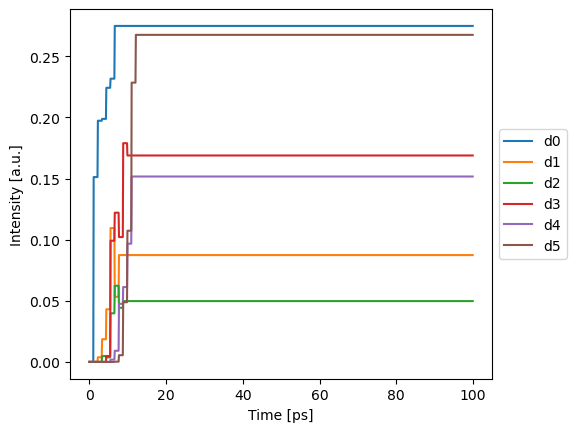

In [9]:
detected_time = network_reck(all_high_input)
network_reck.plot(detected_time[:, 0, :, 0]); # plot first and only batch
# convergence analysis 
labels = network_reck.detectors
         

                
detected_time[:, 0, :, 0]

In [ ]:
pt.set_environment(env_fd)
detected_freq_mag = network_reck(all_high_input)[:,0,:,0]
detected_freq_mag = detected_freq_mag.detach().numpy()[0]
plt.bar(np.arange(0,N),detected_freq_mag)
print(f"totaloutput", np.sum(detected_freq_mag))
plt.title("Output Magnitude")